# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer, load_wine
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [2]:

# 데이터셋 종류 :
# data = load_breast_cancer()
data = load_wine()

In [3]:
input = data.data
output = data.target

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

In [6]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

print('\n',x_train[0].size(), torch.unique(y_train), len(x_train))
# wine 데이터의 input 13개, y의 class 는 0, 1, 2로 3개

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03], device='cuda:0')
tensor(0, device='cuda:0')

 torch.Size([13]) tensor([0, 1, 2], device='cuda:0') 124


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [8]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [9]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

In [10]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기
'''
model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True),
          nn.Softmax()
          ).to(device)
'''
model = nn.Sequential(
          nn.Linear(x_train[0].size()[0],398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True),
          nn.Softmax(dim=1)
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [11]:
'''
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(30,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output
'''
print()

In [69]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()

    self.layer1 = nn.Sequential(
          nn.Linear(x_train[0].size()[0], 398, bias=True),
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True),
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True),
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True),
        nn.Softmax(dim=1)
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [70]:
class Model(torch.nn.Module):

  def __init__(self, nin, n1, n2, n3, n4):
    super(Model, self).__init__()

    self.layer1 = nn.Sequential(
          nn.Linear(nin, n1, bias=True),
          nn.Sigmoid(),
        nn.BatchNorm1d(n1)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(n1,n2, bias=True),
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(n2,n3, bias=True),
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(n3, n4, bias=True),
        nn.Softmax(dim=1)
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [82]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [72]:
nin = x_train[0].size()[0]
nout = 3
n1 = 400
n2 = 100
n3 = 50

model = Model(nin, n1, n2, n3, nout).to(device)
model.apply(init_weights)

<ipython-input-71-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=400, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=50, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)

In [73]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=400, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=50, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)


In [74]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.Adam(model.parameters(), lr=0.01)


# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [28]:
optimizer_classes = [name for name in dir(optim) if name[0].isupper()]
print(optimizer_classes)

['ASGD', 'Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'LBFGS', 'NAdam', 'Optimizer', 'RAdam', 'RMSprop', 'Rprop', 'SGD', 'SparseAdam']


In [75]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1359058618545532
10 0.8627452850341797
20 0.8525475263595581
30 0.8464255332946777
40 0.7973694205284119
50 0.6658904552459717
60 0.6376820802688599
70 0.6004887819290161
80 0.6206172108650208
90 0.5982028841972351


In [80]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9921358e-01 1.0115174e-06 7.8545825e-04]
argmax를 한 후의 output은 0
accuracy는 0.8888888888888888


## Overfitting 인 건 맞는데... train-valid 나누지 않고 진행하는 상황이고, accuracy 1.0 나온 만큼 2layer 진행할 필요는 없을 것으로 판단.

In [99]:
nin = x_train[0].size()[0]
nout = 3
n1_ = np.random.randint(200, 501, size=100)
n2_ = np.random.randint(80, 151, size=100)
n3_ = np.random.randint(20, 71, size=100)

acc_list = []

for i in range(100):

  n1, n2, n3 = n1_[i], n2_[i], n3_[i]
  model = Model(nin, n1, n2, n3, nout).to(device)
  model.apply(init_weights)

  # 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'RAdam', 'RMSprop', 'SGD'

  loss_fn  = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  losses = []
  for epoch in range(100):
    optimizer.zero_grad()
    hypothesis = model(x_train)
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

  with torch.no_grad():
    model = model.to('cpu')
    y_pred = model(x_test)
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis =1)
    accuracy = (accuracy_score(predicted, y_test))
    acc_list.append(accuracy)
  print(f'accuracy는 {accuracy:.4f}')

print()
idx = np.argmax(acc_list)
print(f'best : {np.max(acc_list)},  {n1_[idx]},{n2_[idx]},{n3_[idx]}')

accuracy는 0.9815
accuracy는 0.9259
accuracy는 0.9259
accuracy는 0.9630
accuracy는 0.7963
accuracy는 0.8889
accuracy는 0.9259
accuracy는 0.9444
accuracy는 0.8889
accuracy는 0.9259
accuracy는 0.9074
accuracy는 0.9630
accuracy는 0.8148
accuracy는 0.9259
accuracy는 0.8889
accuracy는 0.9259
accuracy는 0.8333
accuracy는 0.8519
accuracy는 0.9259
accuracy는 0.9259
accuracy는 0.9259
accuracy는 0.6481
accuracy는 0.7963
accuracy는 0.9444
accuracy는 0.8704
accuracy는 0.9259
accuracy는 0.9630
accuracy는 0.6111
accuracy는 0.8889
accuracy는 0.8704
accuracy는 0.9259
accuracy는 0.9074
accuracy는 0.9630
accuracy는 0.8704
accuracy는 0.8704
accuracy는 0.9630
accuracy는 0.9630
accuracy는 0.9630
accuracy는 0.9074
accuracy는 0.8519
accuracy는 0.8519
accuracy는 0.8889
accuracy는 0.8333
accuracy는 0.9815
accuracy는 0.9259
accuracy는 0.9630
accuracy는 0.9630
accuracy는 0.9444
accuracy는 0.7778
accuracy는 0.9630
accuracy는 0.9259
accuracy는 0.9630
accuracy는 0.9815
accuracy는 0.9630
accuracy는 0.8519
accuracy는 0.9815
accuracy는 0.9815
accuracy는 0.9630
accuracy는 0.79

In [103]:
optim_list = ['Adagrad', 'Adam', 'AdamW', 'Adamax', 'RAdam', 'RMSprop', 'SGD']

nin = x_train[0].size()[0]
nout = 3
n1_ = np.random.randint(280, 321, size=40)
n2_ = np.random.randint(100, 141, size=40)
n3_ = np.random.randint(25, 46, size=40)

acc_dict = {'acc': 0}

for idx in range(7):
  for i in range(40):
    for lr in np.logspace(-3, -2, 10):
      n1, n2, n3 = n1_[i], n2_[i], n3_[i]
      model = Model(nin, n1, n2, n3, nout).to(device)
      model.apply(init_weights)

      # 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'RAdam', 'RMSprop', 'SGD'

      loss_fn  = nn.CrossEntropyLoss().to(device)
      if idx == 0:  optimizer = optim.Adagrad(model.parameters(), lr=lr)
      if idx == 1:  optimizer = optim.Adam(model.parameters(), lr=lr)
      if idx == 2:  optimizer = optim.AdamW(model.parameters(), lr=lr)
      if idx == 3:  optimizer = optim.Adamax(model.parameters(), lr=lr)
      if idx == 4:  optimizer = optim.RAdam(model.parameters(), lr=lr)
      if idx == 5:  optimizer = optim.RMSprop(model.parameters(), lr=lr)
      if idx == 6:  optimizer = optim.SGD(model.parameters(), lr=lr)
      losses = []
      for epoch in range(100):
        optimizer.zero_grad()
        hypothesis = model(x_train)
        cost = loss_fn(hypothesis, y_train)
        cost.backward()
        optimizer.step()
        losses.append(cost.item())

      with torch.no_grad():
        model = model.to('cpu')
        y_pred = model(x_test)
        y_pred = y_pred.detach().numpy()
        predicted = np.argmax(y_pred, axis =1)
        accuracy = (accuracy_score(predicted, y_test))
        if acc_dict['acc'] < accuracy:
          acc_dict['acc'] = accuracy
          acc_dict['optim'] = optim_list[idx]
          acc_dict['lr'] = lr
          acc_dict['n1'] = n1
          acc_dict['n2'] = n2
          acc_dict['n3'] = n3
          acc_dict['loss'] = losses
      #print(f'accuracy는 {accuracy:.4f}')


print(f'''best_accuracy : {acc_dict['acc']},
      optimizer : {acc_dict['optim']},
      learning_rate : {acc_dict['lr']},
      hidden_nodes : {acc_dict['n1']}, {acc_dict['n2']}, {acc_dict['n3']},
      ''')

best_accuracy : 1.0,
      optimizer : Adagrad,
      learning_rate : 0.003593813663804626,
      hidden_nodes : 307, 104, 33,
      


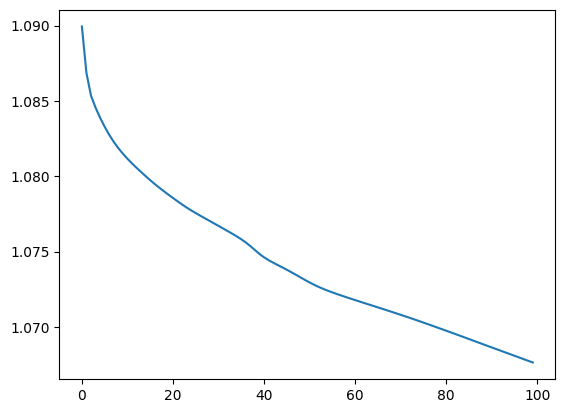

In [104]:
plt.plot(losses)
plt.show()

# < 3주차 과제 2 : CNN 맛보기>

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 151176158.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 96753749.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47193275.72it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18370808.84it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
len(train_dataset), train_dataset[0][0].size()

(60000, torch.Size([1, 28, 28]))

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(4 * 4 * 20 , 10) ### : 알맞는 input은?

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    #return F.log_softmax(x)
    '''
    <ipython-input-24-5c2d5110dbb5>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
      return F.log_softmax(x)

    UserWarning 에 따라서 차원을 명시화.
    '''
    return F.log_softmax(x, dim=1)


In [ ]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [ ]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test():
    model.eval() #model.eval() 의 기능은?
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        '''
         <ipython-input-21-f52337105c2a>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
        data, target = Variable(data, volatile=True), Variable(target)

        volatile=True 더 이상 사용되지 않음.
        with torch.no_grad() 내에서 data, target 변수 불러오는게 타당한 듯 보임.
        '''
        with torch.no_grad():
          data, target = Variable(data), Variable(target)
        output = model(data)
        #test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        '''
        /usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
        warnings.warn(warning.format(ret))

        size_average=False 기능 곧 사진다는 UserWarning
        '''
        test_loss += F.nll_loss(output, target, reduction='sum').data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313982
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.311526
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.286257
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.280571
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264812
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.244339
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.228913
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.153345
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.126422
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.076624
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.884866
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.676399
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.519793
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.371693
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.059892
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.897721
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.931941
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.697954
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.595195
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.586475
Train Epoch: 1 [12800/60000 (